<a href="https://colab.research.google.com/github/yyuukkee/Algorithmic-Trading-and-High-Frequency-Finance/blob/main/Evaluating_the_Effectiveness_of_a_Filter_Rule_Trading_Strategy_A_Case_Study_on_Microsoft_(MSFT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pytz
import warnings
from scipy.stats import norm
from datetime import datetime as dt
import statsmodels.api as sm
from scipy.stats import wilcoxon
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

In [ ]:
ticker = "MSFT"
start_date = "2020-01-01"
end_date = "2025-01-01"

MSFT_data = yf.download(ticker, start=start_date, end=end_date, interval="1d",auto_adjust=False)
MSFT_data = MSFT_data.droplevel(1, axis=1)
print()
print(MSFT_data.head())
print(MSFT_data.tail())

[*********************100%***********************]  1 of 1 completed


Price        Adj Close       Close        High         Low        Open  \
Date                                                                     
2020-01-02  153.323288  160.619995  160.729996  158.330002  158.779999   
2020-01-03  151.414124  158.619995  159.949997  158.059998  158.320007   
2020-01-06  151.805481  159.029999  159.100006  156.509995  157.080002   
2020-01-07  150.421417  157.580002  159.669998  157.320007  159.320007   
2020-01-08  152.817352  160.089996  160.800003  157.949997  158.929993   

Price         Volume  
Date                  
2020-01-02  22622100  
2020-01-03  21116200  
2020-01-06  20813700  
2020-01-07  21634100  
2020-01-08  27746500  
Price        Adj Close       Close        High         Low        Open  \
Date                                                                     
2024-12-24  438.450836  439.329987  439.600006  434.190002  434.649994   
2024-12-26  437.233276  438.109985  440.940002  436.630005  439.079987   
2024-12-27  429.668457 

In [ ]:
MSFT_data1 = yf.download(ticker, start=start_date, end=end_date)
print(MSFT_data1.head())
print(MSFT_data1.tail())

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker            MSFT        MSFT        MSFT        MSFT      MSFT
Date                                                                
2020-01-02  153.323242  153.428246  151.137280  151.566834  22622100
2020-01-03  151.414124  152.683705  150.879566  151.127764  21116200
2020-01-06  151.805496  151.872323  149.399972  149.944085  20813700
2020-01-07  150.421402  152.416453  150.173219  152.082362  21634100
2020-01-08  152.817398  153.495150  150.774615  151.710091  27746500
Price            Close        High         Low        Open    Volume
Ticker            MSFT        MSFT        MSFT        MSFT      MSFT
Date                                                                
2024-12-24  438.450836  438.720315  433.321138  433.780209   7164500
2024-12-26  437.233276  440.057630  435.756258  438.201337   8194200
2024-12-27  429.668457  434.349074  425.496829  433.730320  18117700
2024-12-30  423.979858  426.694417

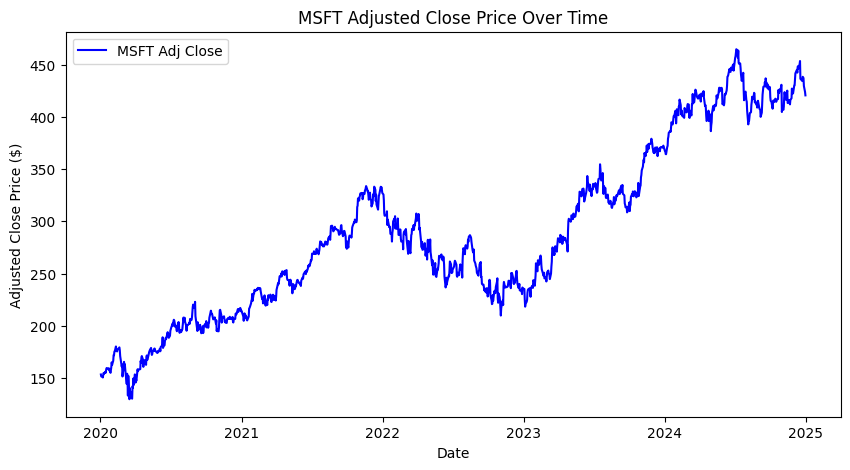

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(MSFT_data.index, MSFT_data["Adj Close"], label="MSFT Adj Close", color="blue")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price ($)")
plt.title("MSFT Adjusted Close Price Over Time")
plt.legend()
plt.show()

In [ ]:
n = 15
MSFT_data["M_k"] = MSFT_data["Close"].rolling(window=n).max()
MSFT_data["m_k"] = MSFT_data["Close"].rolling(window=n).min()
print(MSFT_data.head())
print(MSFT_data.tail())

Price        Adj Close       Close        High         Low        Open  \
Date                                                                     
2020-01-02  153.323242  160.619995  160.729996  158.330002  158.779999   
2020-01-03  151.414124  158.619995  159.949997  158.059998  158.320007   
2020-01-06  151.805496  159.029999  159.100006  156.509995  157.080002   
2020-01-07  150.421402  157.580002  159.669998  157.320007  159.320007   
2020-01-08  152.817398  160.089996  160.800003  157.949997  158.929993   

Price         Volume  M_k  m_k  
Date                            
2020-01-02  22622100  NaN  NaN  
2020-01-03  21116200  NaN  NaN  
2020-01-06  20813700  NaN  NaN  
2020-01-07  21634100  NaN  NaN  
2020-01-08  27746500  NaN  NaN  
Price        Adj Close       Close        High         Low        Open  \
Date                                                                     
2024-12-24  438.450836  439.329987  439.600006  434.190002  434.649994   
2024-12-26  437.233276  438.

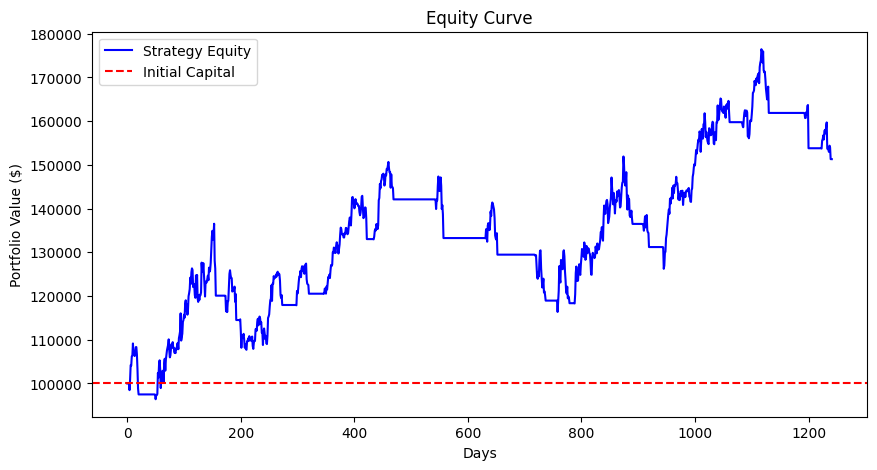

In [ ]:
initial_capital = 100000
cash = initial_capital
position = 0
buy_threshold = 1.01
sell_threshold = 0.99
slippage = 0.0005
risk_free_rate = 0.02  # Assume 2% annual risk-free rate

daily_returns = []
downside_returns = []
drawdowns = []
equity_curve = []
trade_log = []
round_trip_trades = 0
winning_trades = 0
losing_trades = 0
entry_price = 0

for i in range(n+1, len(MSFT_data)):
    current_price = MSFT_data["Close"].iloc[i]
    current_price_adjust = MSFT_data["Adj Close"].iloc[i]
    max_price = MSFT_data["M_k"].iloc[i-1]
    min_price = MSFT_data["m_k"].iloc[i-1]

    buy_signal = current_price > buy_threshold * max_price
    sell_signal = current_price < sell_threshold * min_price

    if buy_signal and cash >= current_price:
        execution_price = current_price * (1 + slippage)
        shares_to_buy = int(cash / execution_price)
        cost = shares_to_buy * execution_price
        position += shares_to_buy
        cash -= cost
        entry_price = execution_price
        entry_price_adjust = current_price_adjust
        trade_log.append(f"Buy {shares_to_buy} shares at {execution_price:.2f} on {MSFT_data.index[i].date()}")

    elif sell_signal and position > 0:
        execution_price = entry_price * current_price_adjust / entry_price_adjust * (1 - slippage)
        cash += position * execution_price

        round_trip_trades += 1
        if execution_price > entry_price:
            winning_trades += 1
        else:
            losing_trades += 1

        trade_log.append(f"Sell {position} shares at {execution_price:.2f} on {MSFT_data.index[i].date()}")
        position = 0

    current_equity = cash + position * current_price
    equity_curve.append(current_equity)

    if position > 0:
        daily_return = (equity_curve[-1] - equity_curve[-2]) / equity_curve[-2]
        daily_returns.append(daily_return)
        if daily_return < 0:
            downside_returns.append(daily_return)

    peak = max(equity_curve)
    drawdown = (peak - current_equity) / peak
    drawdowns.append(drawdown)

final_value = cash + position * MSFT_data["Close"].iloc[-1]
trade_log.append(f"Final Portfolio Value: ${final_value:.2f}")
plt.figure(figsize=(10, 5))
plt.plot(equity_curve, label="Strategy Equity", color="blue")
plt.axhline(y=initial_capital, color='r', linestyle='--', label="Initial Capital")
plt.xlabel("Days")
plt.ylabel("Portfolio Value ($)")
plt.title("Equity Curve")
plt.legend()
plt.show()

In [ ]:
for i, log in enumerate(trade_log, 1):
    print(log, end="  ")
    if i % 2 == 0:
        print()

Buy 578 shares at 172.87 on 2020-01-30  Sell 578 shares at 168.53 on 2020-02-25  
Buy 589 shares at 165.35 on 2020-04-06  Sell 589 shares at 203.72 on 2020-09-08  
Buy 564 shares at 212.57 on 2020-10-01  Sell 564 shares at 202.68 on 2020-10-28  
Buy 512 shares at 223.40 on 2020-11-05  Sell 512 shares at 230.12 on 2021-02-25  
Buy 486 shares at 242.47 on 2021-04-01  Sell 486 shares at 247.79 on 2021-05-04  
Buy 468 shares at 257.37 on 2021-06-10  Sell 468 shares at 284.06 on 2021-09-28  
Buy 439 shares at 302.90 on 2021-10-14  Sell 439 shares at 323.60 on 2021-12-03  
Buy 467 shares at 304.21 on 2022-03-22  Sell 467 shares at 285.26 on 2022-04-11  
Buy 481 shares at 276.55 on 2022-07-28  Sell 481 shares at 268.66 on 2022-08-26  
Buy 507 shares at 255.27 on 2022-11-30  Sell 507 shares at 234.53 on 2022-12-28  
Buy 479 shares at 248.12 on 2023-01-26  Sell 479 shares at 246.89 on 2023-03-01  
Buy 453 shares at 260.92 on 2023-03-14  Sell 453 shares at 275.42 on 2023-04-25  
Buy 422 shares a

In [ ]:
# Calculate performance metrics
total_return = ((final_value - initial_capital) / initial_capital) * 100
buy_and_hold_return = ((MSFT_data["Adj Close"].iloc[-1] - MSFT_data["Adj Close"].iloc[0]) / MSFT_data["Adj Close"].iloc[0]) * 100
win_rate = (winning_trades / round_trip_trades) * 100 if round_trip_trades > 0 else 0
max_drawdown = max(drawdowns) * 100

# Sharpe Ratio
if len(daily_returns) > 1:
    daily_std = np.std(daily_returns, ddof=1)
    sharpe_ratio = ((np.mean(daily_returns)*252 - risk_free_rate ) / daily_std) / np.sqrt(len(daily_returns)//5)
else:
    sharpe_ratio = np.nan

# Calmar Ratio
calmar_ratio = ((total_return/100+1)**(1/5)-1) / (max_drawdown/100) if max_drawdown != 0 else np.nan

# Buy & Hold Sharpe Ratio
buy_and_hold_daily_returns = MSFT_data["Adj Close"].pct_change().dropna()
buy_and_hold_sharpe = ((buy_and_hold_daily_returns.mean() - risk_free_rate / 252) / buy_and_hold_daily_returns.std()) * np.sqrt(252)
performance_data = {
    "Sample": ["Historical"],
    "# of round-trip trades": [round_trip_trades],
    "Total return, %": [round(total_return, 2)],
    "Sharpe Ratio": [round(sharpe_ratio, 3)],
    "B & H return, %": [round(buy_and_hold_return, 2)],
    "B & H Sharpe Ratio": [round(buy_and_hold_sharpe, 3)],
    "Winning trades, %": [round(win_rate, 2)],
    "Max drawdown, %": [round(max_drawdown, 2)],
    "Calmar Ratio": [round(calmar_ratio, 3)]
}

performance_df = pd.DataFrame(performance_data)
print(performance_df)

       Sample  # of round-trip trades  Total return, %  Sharpe Ratio  \
0  Historical                      18            51.32         1.839   

   B & H return, %  B & H Sharpe Ratio  Winning trades, %  Max drawdown, %  \
0           174.36               0.751               50.0            22.77   

   Calmar Ratio  
0         0.379  


In [ ]:
MSFT_data['Log_Returns'] = np.log(MSFT_data['Adj Close'] / MSFT_data['Adj Close'].shift(1))
MSFT_data = MSFT_data.dropna(subset=['Log_Returns'])
print(MSFT_data.head())

Price        Adj Close       Close        High         Low        Open  \
Date                                                                     
2020-01-03  151.414124  158.619995  159.949997  158.059998  158.320007   
2020-01-06  151.805496  159.029999  159.100006  156.509995  157.080002   
2020-01-07  150.421402  157.580002  159.669998  157.320007  159.320007   
2020-01-08  152.817398  160.089996  160.800003  157.949997  158.929993   
2020-01-09  154.726440  162.089996  162.220001  161.029999  161.839996   

Price         Volume  M_k  m_k  Log_Returns  
Date                                         
2020-01-03  21116200  NaN  NaN    -0.012530  
2020-01-06  20813700  NaN  NaN     0.002581  
2020-01-07  21634100  NaN  NaN    -0.009159  
2020-01-08  27746500  NaN  NaN     0.015803  
2020-01-09  21385000  NaN  NaN     0.012415  


In [ ]:
y = MSFT_data['Log_Returns'][1:]
X = sm.add_constant(MSFT_data['Log_Returns'][:-1])
X.index = y.index
model = sm.OLS(y, X).fit()
alpha, beta = model.params
residuals = y - model.predict(X)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Log_Returns   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     41.67
Date:                Sun, 02 Mar 2025   Prob (F-statistic):           1.54e-10
Time:                        18:20:31   Log-Likelihood:                 3201.5
No. Observations:                1256   AIC:                            -6399.
Df Residuals:                    1254   BIC:                            -6389.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0010      0.001      1.794      

In [ ]:
bootstrap_residuals = np.random.choice(residuals, size=len(residuals), replace=True)
new_log_returns = [MSFT_data['Log_Returns'].iloc[0]]
for i in range(1, len(MSFT_data)):
    new_r = alpha + beta * new_log_returns[-1] + bootstrap_residuals[i - 1]
    new_log_returns.append(new_r)
new_log_returns = np.array(new_log_returns)

In [ ]:
new_prices = [MSFT_data['Adj Close'].iloc[0]]
for r in new_log_returns:
    new_prices.append(new_prices[-1] * np.exp(r))
new_prices = np.array(new_prices)

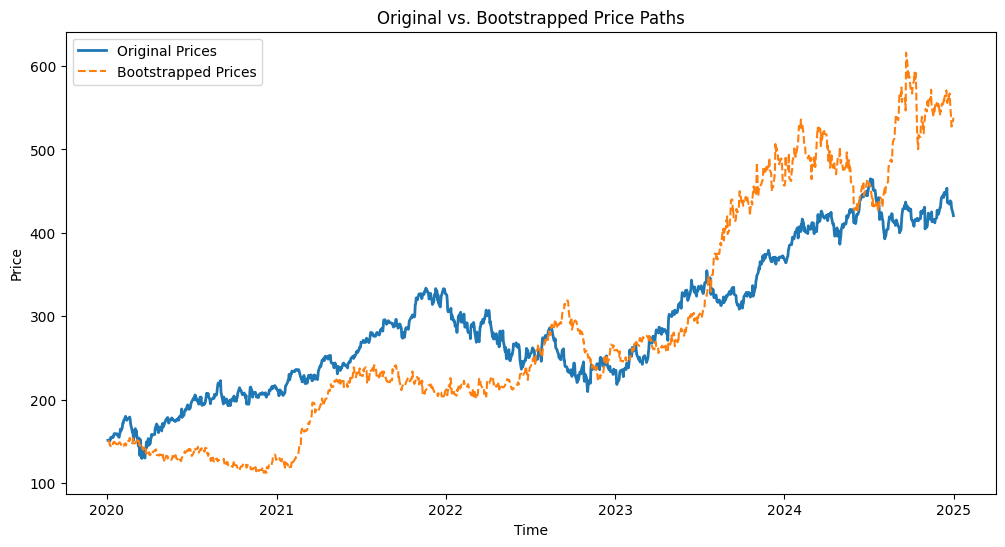

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(MSFT_data.index, MSFT_data['Adj Close'], label="Original Prices", linewidth=2)
plt.plot(MSFT_data.index, new_prices[:-1], label="Bootstrapped Prices", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.title("Original vs. Bootstrapped Price Paths")
plt.show()

In [ ]:
n_bootstrap = 100
bootstrap_results = []

for b in range(n_bootstrap):
    bootstrap_residuals = np.random.choice(residuals, size=len(residuals), replace=True)

    new_log_returns = [MSFT_data['Log_Returns'].iloc[0]]
    for i in range(1, len(MSFT_data)):
        new_r = alpha + beta * new_log_returns[-1] + bootstrap_residuals[i - 1]
        new_log_returns.append(new_r)
    new_log_returns = np.array(new_log_returns)

    new_prices = [MSFT_data['Adj Close'].iloc[0]]
    for r in new_log_returns:
        new_prices.append(new_prices[-1] * np.exp(r))
    new_prices = np.array(new_prices)

    df_bootstrap = MSFT_data.iloc[1:].copy()
    df_bootstrap["Bootstrap_Price"] = new_prices[:len(df_bootstrap)]
    df_bootstrap["M_k"] = df_bootstrap["Bootstrap_Price"].rolling(window=n).max()
    df_bootstrap["m_k"] = df_bootstrap["Bootstrap_Price"].rolling(window=n).min()

    cash = initial_capital
    position = 0

    daily_returns = []
    downside_returns = []
    drawdowns = []
    equity_curve = []
    trade_log = []
    round_trip_trades = 0
    winning_trades = 0
    losing_trades = 0
    entry_price = 0

    for i in range(n+1, len(df_bootstrap)):
        current_price = df_bootstrap["Bootstrap_Price"].iloc[i]
        #current_price_adjust = MSFT_data["Adj Close"].iloc[i]
        max_price = df_bootstrap["M_k"].iloc[i-1]
        min_price = df_bootstrap["m_k"].iloc[i-1]

        buy_signal = current_price > buy_threshold * max_price
        sell_signal = current_price < sell_threshold * min_price

        if buy_signal and cash >= current_price:
            execution_price = current_price * (1 + slippage)
            shares_to_buy = int(cash / execution_price)
            cost = shares_to_buy * execution_price
            position += shares_to_buy
            cash -= cost
            entry_price = execution_price
            entry_price_adjust = current_price
            trade_log.append(f"Buy {shares_to_buy} shares at {execution_price:.2f} on {df_bootstrap.index[i].date()}")

        elif sell_signal and position > 0:
            execution_price = entry_price * current_price / entry_price_adjust * (1 - slippage)
            cash += position * execution_price

            round_trip_trades += 1
            if execution_price > entry_price:
                winning_trades += 1
            else:
                losing_trades += 1

            trade_log.append(f"Sell {position} shares at {execution_price:.2f} on {df_bootstrap.index[i].date()}")
            position = 0

        current_equity = cash + position * current_price
        equity_curve.append(current_equity)

        if position > 0 and len(equity_curve)>1:
            daily_return = (equity_curve[-1] - equity_curve[-2]) / equity_curve[-2]
            daily_returns.append(daily_return)
            if daily_return < 0:
                downside_returns.append(daily_return)

        peak = max(equity_curve)
        drawdown = (peak - current_equity) / peak
        drawdowns.append(drawdown)
    final_value = cash + position * df_bootstrap["Bootstrap_Price"].iloc[-1]
    # Calculate performance metrics
    total_return = ((final_value - initial_capital) / initial_capital) * 100
    buy_and_hold_return = ((df_bootstrap["Bootstrap_Price"].iloc[-1] - df_bootstrap["Bootstrap_Price"].iloc[0]) / df_bootstrap["Bootstrap_Price"].iloc[0]) * 100
    win_rate = (winning_trades / round_trip_trades) * 100 if round_trip_trades > 0 else 0
    max_drawdown = max(drawdowns) * 100

    # Sharpe Ratio
    if len(daily_returns) > 1:
        daily_std = np.std(daily_returns, ddof=1)
        sharpe_ratio = ((np.mean(daily_returns)*252 - risk_free_rate ) / daily_std) / np.sqrt(len(daily_returns)//5)
    else:
        sharpe_ratio = np.nan

    # Calmar Ratio
    calmar_ratio = ((total_return/100+1)**(1/5)-1) / (max_drawdown/100) if max_drawdown != 0 else np.nan

    # Buy & Hold Sharpe Ratio
    buy_and_hold_daily_returns = df_bootstrap["Bootstrap_Price"].pct_change().dropna()
    buy_and_hold_sharpe = ((buy_and_hold_daily_returns.mean() - risk_free_rate / 252) / buy_and_hold_daily_returns.std()) * np.sqrt(252)
    bootstrap_results.append([
        round_trip_trades, round(total_return, 2), round(sharpe_ratio, 2),
        round(buy_and_hold_return, 2), round(buy_and_hold_sharpe, 2),
        round(win_rate, 2), round(max_drawdown, 2),round(calmar_ratio, 2)
    ])


bootstrap_results_df = pd.DataFrame(bootstrap_results, columns=[
    "# of round-trip trades", "Total return, %", "Sharpe Ratio",
    "B & H return, %", "B & H Sharpe Ratio",
    "Winning trades, %", "Max drawdown, %", "Calmar Ratio"
])

bootstrap_avg = bootstrap_results_df.mean().to_frame().T
bootstrap_avg.insert(0, "Sample", "Average")

bootstrap_results_df.insert(0, "Sample", [f"B{i+1}" for i in range(n_bootstrap)])
bootstrap_results_df = pd.concat([bootstrap_results_df, bootstrap_avg])
performance_df.index = ['Historical']
bootstrap_results_df = pd.concat([performance_df, bootstrap_results_df], axis=0)
print(bootstrap_results_df)

                Sample  # of round-trip trades  Total return, %  Sharpe Ratio  \
Historical  Historical                   18.00          51.3200        1.8390   
0                   B1                   16.00          42.6600        1.7800   
1                   B2                   21.00          91.6200        1.7600   
2                   B3                   16.00         592.7700        2.8700   
3                   B4                   16.00         226.0500        2.2900   
...                ...                     ...              ...           ...   
96                 B97                   17.00          34.0300        2.4200   
97                 B98                   18.00          50.4200        2.2600   
98                 B99                   21.00         -39.8700        0.5900   
99                B100                   20.00          37.4400        1.7000   
0              Average                   18.03          71.5354        1.8743   

            B & H return, %

In [ ]:
bootstrap_results_df.to_csv("bootstrap_results.csv", index=False)

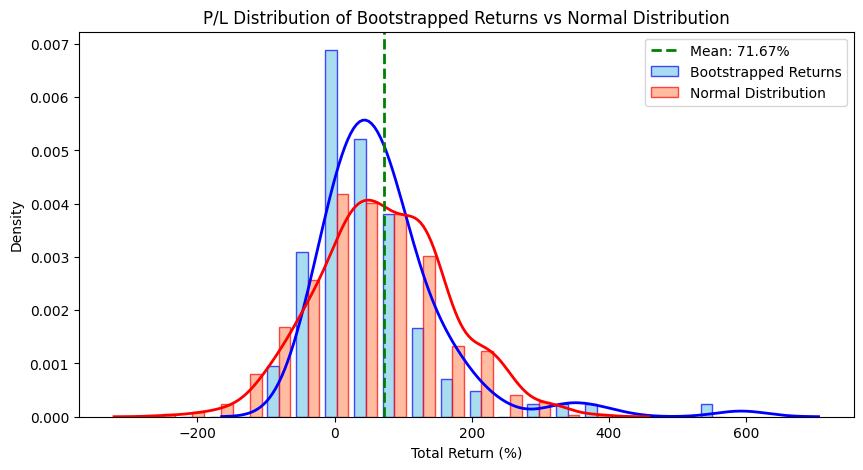

In [ ]:
pl_returns = bootstrap_results_df["Total return, %"][:100].to_numpy()
mean_return = np.mean(pl_returns)
std_return = np.std(pl_returns)
normal_samples = np.random.normal(mean_return, std_return, size=1000)

bins = np.histogram_bin_edges(np.concatenate([pl_returns, normal_samples]), bins=20)
hist_pl, bins_pl = np.histogram(pl_returns, bins=bins, density=True)
hist_norm, bins_norm = np.histogram(normal_samples, bins=bins, density=True)

bar_width = (bins[1] - bins[0]) * 0.4
x_pl = bins[:-1] - bar_width / 2
x_norm = bins[:-1] + bar_width / 2

light_blue = "#87CEEB"
light_red = "#FFA07A"

plt.figure(figsize=(10, 5))
plt.bar(x_pl, hist_pl, width=bar_width, color=light_blue, alpha=0.7, edgecolor="blue", label="Bootstrapped Returns")
plt.bar(x_norm, hist_norm, width=bar_width, color=light_red, alpha=0.7, edgecolor="red", label="Normal Distribution")

sns.kdeplot(pl_returns, color="blue", linewidth=2)
sns.kdeplot(normal_samples, color="red", linewidth=2)

plt.axvline(mean_return, color="green", linestyle="dashed", linewidth=2, label=f"Mean: {mean_return:.2f}%")

plt.legend()
plt.title("P/L Distribution of Bootstrapped Returns vs Normal Distribution")
plt.xlabel("Total Return (%)")
plt.ylabel("Density")
plt.show()


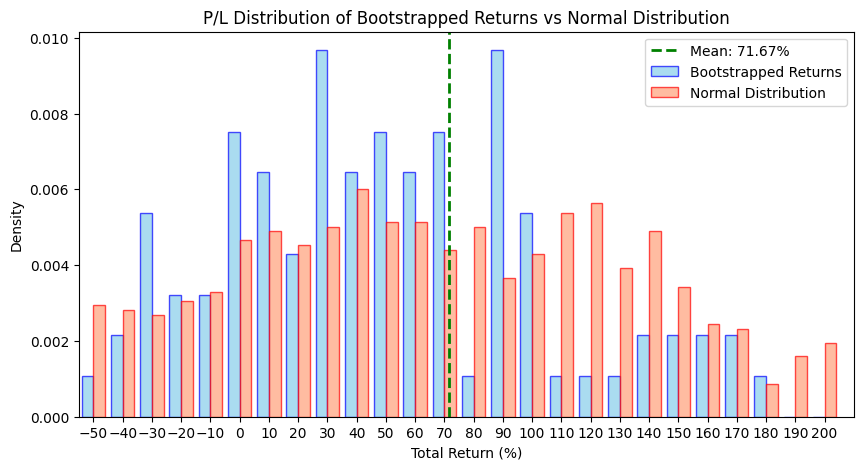

In [ ]:
bins = np.arange(-50, 210, 10)

hist_pl, bins_pl = np.histogram(pl_returns, bins=bins, density=True)
hist_norm, bins_norm = np.histogram(normal_samples, bins=bins, density=True)

bar_width = (bins[1] - bins[0]) * 0.4
x_pl = bins[:-1] - bar_width / 2
x_norm = bins[:-1] + bar_width / 2

plt.figure(figsize=(10, 5))
plt.bar(x_pl, hist_pl, width=bar_width, color=light_blue, alpha=0.7, edgecolor="blue", label="Bootstrapped Returns")
plt.bar(x_norm, hist_norm, width=bar_width, color=light_red, alpha=0.7, edgecolor="red", label="Normal Distribution")

plt.axvline(mean_return, color="green", linestyle="dashed", linewidth=2, label=f"Mean: {mean_return:.2f}%")

plt.legend()
plt.title("P/L Distribution of Bootstrapped Returns vs Normal Distribution")
plt.xlabel("Total Return (%)")
plt.ylabel("Density")
plt.xticks(np.arange(-50, 210, 10))
plt.xlim(-55, 210)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm

pl_returns = bootstrap_results_df["Total return, %"][:100].to_numpy()
bins = np.arange(-50, 220, 10)
count, bin_edges = np.histogram(pl_returns, bins=bins)
density = count / np.sum(count)
mean_return = np.mean(pl_returns)
std_return = np.std(pl_returns)
pl_values = bin_edges[:-1]
normal_density = norm.pdf(pl_values, loc=mean_return, scale=std_return)
lse = (density - normal_density) ** 2

df = pd.DataFrame({
    "P/L, %": pl_values,
    "Count": count,
    "Density": density,
    "N(F1,G1)": normal_density,
    "LSE": lse
})

print(df)


    P/L, %  Count   Density  N(F1,G1)       LSE
0      -50      1  0.010753  0.001838  0.000079
1      -40      2  0.021505  0.002097  0.000377
2      -30      5  0.053763  0.002365  0.002642
3      -20      3  0.032258  0.002638  0.000877
4      -10      3  0.032258  0.002909  0.000861
5        0      7  0.075269  0.003171  0.005198
6       10      6  0.064516  0.003419  0.003733
7       20      4  0.043011  0.003645  0.001550
8       30      9  0.096774  0.003842  0.008636
9       40      6  0.064516  0.004004  0.003662
10      50      7  0.075269  0.004127  0.005061
11      60      6  0.064516  0.004205  0.003637
12      70      7  0.075269  0.004237  0.005046
13      80      1  0.010753  0.004221  0.000043
14      90      9  0.096774  0.004158  0.008578
15     100      5  0.053763  0.004050  0.002471
16     110      1  0.010753  0.003901  0.000047
17     120      1  0.010753  0.003715  0.000050
18     130      1  0.010753  0.003498  0.000053
19     140      2  0.021505  0.003256  0

In [ ]:
df.to_csv("density_estimation.csv", index=False)

In [ ]:
# Conduct statistical test: check if mean total return is significantly different from zero
t_stat, p_value = ttest_1samp(pl_returns, 0)

# Print test results
print(f"Mean Total Return: {mean_return:.4f}%")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

# Conclusion
alpha = 0.05
if p_value < alpha:
    print("Mean total return is significantly different from zero")
else:
    print("Mean total return is NOT significantly different from zero")

Mean Total Return: 71.6742%
T-statistic: 7.5752, P-value: 0.0000
Mean total return is significantly different from zero


In [ ]:
stat, p_value = wilcoxon(pl_returns)

# Output results
print(f"Wilcoxon Signed-Rank Test statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation of results
alpha = 0.05
if p_value < alpha:
    print("The median is significantly different from 0")
else:
    print("Fail to reject the null hypothesis, the median may be 0")

Wilcoxon Signed-Rank Test statistic: 351.0000
P-value: 0.0000
The median is significantly different from 0
